In [34]:
!git config user.email "naazshafeer@gmail.com"
!git config user.name "Naaz Shafeer"

Modelling 2-Body Problem 

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import scipy as sci
from scipy import integrate
from scipy.integrate import odeint
from matplotlib.patches import Ellipse
from astropy import units as u
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import astropy.constants as const

In [37]:
G = const.G.to(u.m**3 / (u.kg * u.year**2)) #change the innate time to years
#Masses
m1=1e8 * const.M_sun #mass of black hole A 
m2=1e8 * const.M_sun #mass of black hole B
# Will be adding the Standard Gravitational Parameter
mu = const.G.value * (m1.value+m2.value)
#r_i
r1=[1e14,0,0] * u.m
r2=[0,0,0] * u.m
#To arrays
r1=np.array(r1,dtype="float64")
r2=np.array(r2,dtype="float64")

#COM
r_com=(m1*r1+m2*r2)/(m1+m2)
#V_i
v1=[0,1e6, 0] *u.m/u.s
v2=[0,-1e6,0] *u.m/u.s

v1 = v1.to(u.m / u.year)
v2 = v2.to(u.m / u.year)

#To arrays
v1=np.array(v1,dtype="float64")
v2=np.array(v2,dtype="float64")
#Find velocity of COM
v_com=(m1*v1+m2*v2)/(m1+m2)

T = 10 # we can extract a from here - whole time in seconds
N = 50000
delta_t = T/ N




In [38]:
# #WIP Dynamical Friction
# rho = 1e9 #just a filler number becuase I do not know the number 
# #According to the article, 
# f_DF = ((-4*np.pi * G**2 * (m1+m2)**2 * rho)/(v1**3)*f(v_m/c_s)*v_m)

#the f(vm/cs) portion is an equation (has parameters of its own) - specified in the article and that is based on bounded/unbounded (i think)

#But there is also another version(?) in the Galactic Dynamics textbook that has a more simplified version
# A = couloumb force
# f_DF1 = 0.428 * ln(A) * G*(m1+m2)**2/r**2

#Since we got the percent change to be low in teh energy to be low, we can implement the dynamical friction(?)
# Probably add this in the velocity component like a free-body diagram with the force of friction, check with Mya on accuracy of equations.

#Tangential dynamical friction (vectors), might be easy to implement since we already have got array type velocities, positions, etc (?)


In [39]:
def verify_CFL_condition(r1, r2, v1, v2, delta_t, G, m1, m2):
    max_speed = max(np.linalg.norm(v1), np.linalg.norm(v2))
    min_distance = np.linalg.norm(r2 - r1)
    cfl = max_speed * delta_t / min_distance
    print(f"CFL Value: {cfl}")
    return cfl <= 1

cfl_check = verify_CFL_condition(r1, r2, v1, v2, delta_t, G, m1, m2)
print(f"CFL  Satisfied: {cfl_check}")

CFL Value: 6.311520000000001e-05
CFL  Satisfied: True


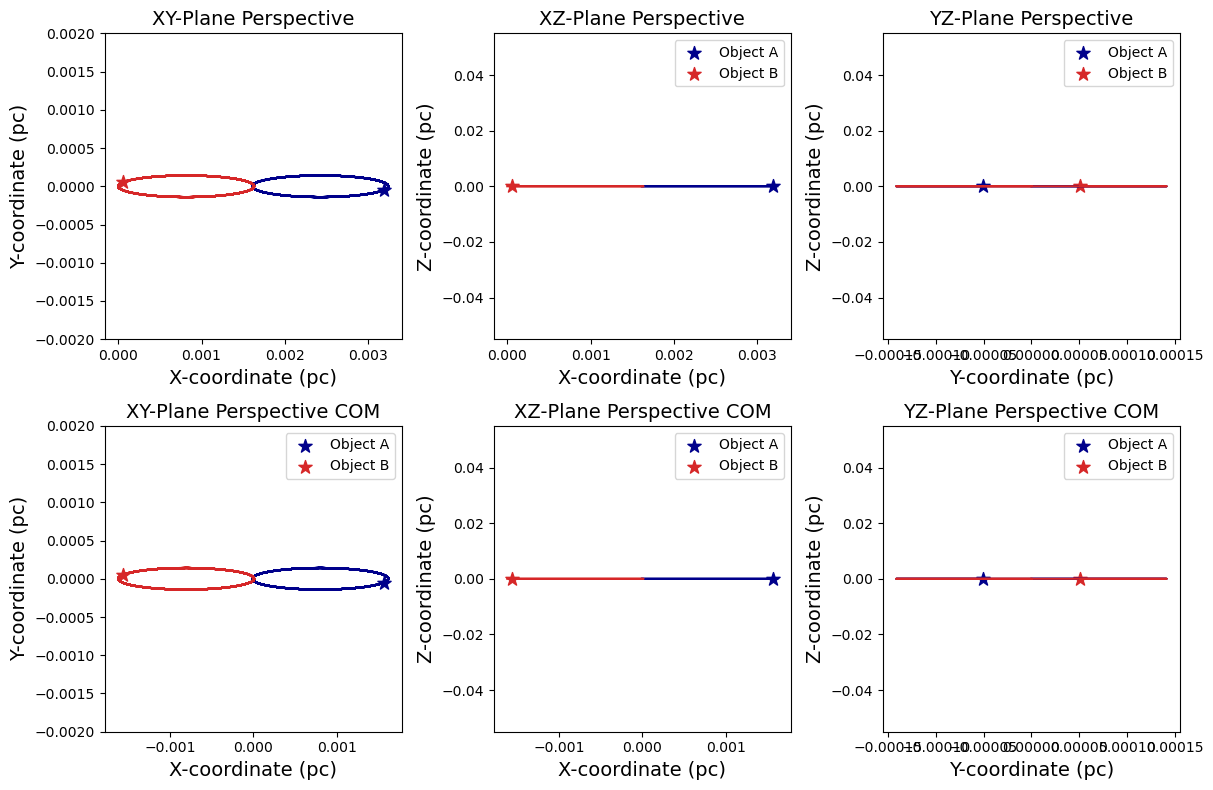

In [51]:
#A function defining the equations of motion 
def TwoBodyEquations(w,t,G,m1,m2):
    r1=w[:3]
    r2=w[3:6]
    v1=w[6:9]
    v2=w[9:12]
    r=np.linalg.norm(r2-r1) #Calculate magnitude or norm of vector
    dv1bydt=G*m2*(r2-r1)/r**3
    dv2bydt=G*m1*(r1-r2)/r**3
    dr1bydt=v1 #.value so odeint doesnt get messed up
    dr2bydt=v2
    r_derivs=np.concatenate((dr1bydt,dr2bydt))
    derivs=np.concatenate((r_derivs,dv1bydt,dv2bydt))
    return derivs
# check what w and t is in the code
#Package initial parameters
init_params=np.array([r1,r2,v1,v2]) #create array of initial params
init_params=init_params.flatten() #flatten array to make it 1D
time_span=np.linspace(0, T, N) #Work on this with Kris' link



two_body_sol=sci.integrate.odeint(TwoBodyEquations,init_params,time_span,args=(G.value,m1.value,m2.value)) #make sure to understand what is within this variable

r1_sol = u.m.to(u.pc, two_body_sol[:, :3])
r2_sol = u.m.to(u.pc, two_body_sol[:, 3:6])

#Find location of COM
rcom_sol=(m1.value*r1_sol+m2.value*r2_sol)/(m1.value+m2.value)

r1com_sol=r1_sol-rcom_sol

r2com_sol=r2_sol-rcom_sol  
#Create figure
fig, axs = plt.subplots(2, 3, figsize=(12, 8)) #looked at article to see how I can line up three differnt persepctives in a row

# region Code Snippet 1: Plot the orbits for XY plane (0,1) in indices
axs[0,0].plot(r1_sol[:,0],r1_sol[:,1],color="darkblue")
axs[0,0].plot(r2_sol[:,0],r2_sol[:,1],color="tab:red")
axs[0,0].set_ylim([-0.002, 0.002])
axs[0,0].scatter(r1_sol[-1,0],r1_sol[-1,1],color="darkblue",marker="*",s=100)
axs[0,0].scatter(r2_sol[-1,0],r2_sol[-1,1],color="tab:red",marker="*",s=100)
axs[0,0].set_xlabel("X-coordinate (pc)",fontsize=14)
axs[0,0].set_ylabel("Y-coordinate (pc)",fontsize=14)
axs[0,0].set_title("XY-Plane Perspective",fontsize=14)

# # Create an inset of the zoomed-in view on the center of mass within the specific subplot
# axins = inset_axes(axs[0, 0], width="30%", height="30%", loc='upper right')  # adjust width and height as needed

# # Plot the center of mass trajectory on the inset
# axins.plot(rcom_sol[:, 0], rcom_sol[:, 1], color="tab:purple")
# axins.scatter(rcom_sol[-1, 0], rcom_sol[-1, 1], color="tab:purple", marker="o", s=100)

# # Set zoomed-in limits
# zoom_margin = 0.0001
# axins.set_xlim(rcom_sol[-1, 0] - zoom_margin, rcom_sol[-1, 0] + zoom_margin)
# axins.set_ylim(rcom_sol[-1, 1] - zoom_margin, rcom_sol[-1, 1] + zoom_margin)

# # Remove inset axis labels
# axins.set_xticklabels([])
# axins.set_yticklabels([])

# # Optionally, add a rectangle in the main plot to highlight the zoomed area
# axs[0, 0].indicate_inset_zoom(axins)

# endregion

# region Code Snippet 2: Plot the orbits for XZ plane (0,2) in indices
axs[0,1].plot(r1_sol[:,0],r1_sol[:,2],color="darkblue")
axs[0,1].plot(r2_sol[:,0],r2_sol[:,2],color="tab:red")
axs[0,1].scatter(r1_sol[-1,0],r1_sol[-1,2],color="darkblue",marker="*",s=100,label="Object A")
axs[0,1].scatter(r2_sol[-1,0],r2_sol[-1,2],color="tab:red",marker="*",s=100,label="Object B")
axs[0,1].set_xlabel("X-coordinate (pc)",fontsize=14)
axs[0,1].set_ylabel("Z-coordinate (pc)",fontsize=14)
axs[0,1].set_title("XZ-Plane Perspective",fontsize=14)
axs[0,1].legend()
# endregion

# region Code Snippet 3: Plot the orbits for YZ plane (1,2) in indices
axs[0,2].plot(r1_sol[:,1],r1_sol[:,2],color="darkblue")
axs[0,2].plot(r2_sol[:,1],r2_sol[:,2],color="tab:red")
axs[0,2].scatter(r1_sol[-1,1],r1_sol[-1,2],color="darkblue",marker="*",s=100,label="Object A")
axs[0,2].scatter(r2_sol[-1,1],r2_sol[-1,2],color="tab:red",marker="*",s=100,label="Object B")
axs[0,2].set_xlabel("Y-coordinate (pc)",fontsize=14)
axs[0,2].set_ylabel("Z-coordinate (pc)",fontsize=14)
axs[0,2].set_title("YZ-Plane Perspective",fontsize=14)
axs[0,2].legend()
# endregion

# region Code Snippet 4: Plot the orbits for XY plane (0,1) in indices but COM
axs[1,0].plot(r1com_sol[:,0],r1com_sol[:,1],color="darkblue")
axs[1,0].plot(r2com_sol[:,0],r2com_sol[:,1],color="tab:red")
axs[1,0].set_ylim([-0.002, 0.002])
# axs[1,0].scatter(rcom_sol[:, 0], rcom_sol[:, 1], color="tab:purple", marker = "*", s = 100, label="Center of Mass Trajectory")
axs[1,0].scatter(r1com_sol[-1,0],r1com_sol[-1,1],color="darkblue",marker="*",s=100,label="Object A")
axs[1,0].scatter(r2com_sol[-1,0],r2com_sol[-1,1],color="tab:red",marker="*",s=100,label="Object B")
axs[1,0].set_xlabel("X-coordinate (pc)",fontsize=14)
axs[1,0].set_ylabel("Y-coordinate (pc)",fontsize=14)
axs[1,0].set_title("XY-Plane Perspective COM",fontsize=14)
axs[1,0].legend()

# endregion

# region Code Snippet 5: Plot the orbits for XZ plane (0,2) in indices but COM
axs[1,1].plot(r1com_sol[:,0],r1com_sol[:,2],color="darkblue")
axs[1,1].plot(r2com_sol[:,0],r2com_sol[:,2],color="tab:red")
axs[1,1].scatter(r1com_sol[-1,0],r1com_sol[-1,2],color="darkblue",marker="*",s=100,label="Object A")
axs[1,1].scatter(r2com_sol[-1,0],r2com_sol[-1,2],color="tab:red",marker="*",s=100,label="Object B")
axs[1,1].set_xlabel("X-coordinate (pc)",fontsize=14)
axs[1,1].set_ylabel("Z-coordinate (pc)",fontsize=14)
axs[1,1].set_title("XZ-Plane Perspective COM",fontsize=14)
axs[1,1].legend()
# endregion

# region Code Snippet 6: Plot the orbits for YZ plane (1,2) in indices but COM
axs[1,2].plot(r1com_sol[:,1],r1com_sol[:,2],color="darkblue")
axs[1,2].plot(r2com_sol[:,1],r2com_sol[:,2],color="tab:red")
axs[1,2].scatter(r1com_sol[-1,1],r1com_sol[-1,2],color="darkblue",marker="*",s=100,label="Object A")
axs[1,2].scatter(r2com_sol[-1,1],r2com_sol[-1,2],color="tab:red",marker="*",s=100,label="Object B")
axs[1,2].set_xlabel("Y-coordinate (pc)",fontsize=14)
axs[1,2].set_ylabel("Z-coordinate (pc)",fontsize=14)
axs[1,2].set_title("YZ-Plane Perspective COM",fontsize=14)
axs[1,2].legend()
# endregion

plt.tight_layout() 
plt.show()



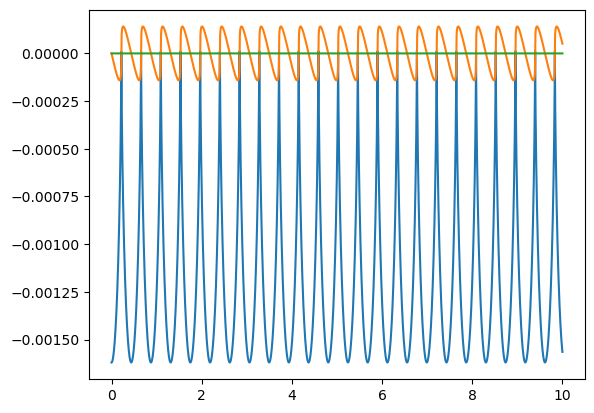

In [41]:
plt.plot(time_span, r2com_sol)

0.15450529211662245
0.0016203896447221824


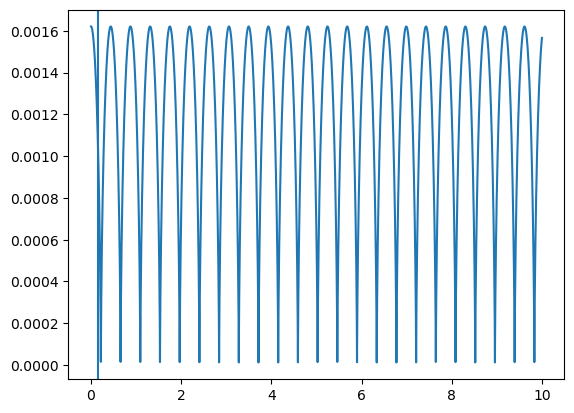

In [49]:
mag = np.sqrt(r2com_sol[:, 0]**2 + r2com_sol[:, 1]**2 + r2com_sol[:, 2]**2)
plt.plot(time_span, mag)
r_a = np.max(mag)
r_p = np.min(mag)
a = (r_a + r_p) / 2


t = np.sqrt((4 * np.pi**2 / mu) * u.pc.to(u.m, a)**3)
print(u.s.to(u.year, t))
plt.axvline(x = 0.1545)
print(T)

Simulated Orbital Period: 0.437009 years


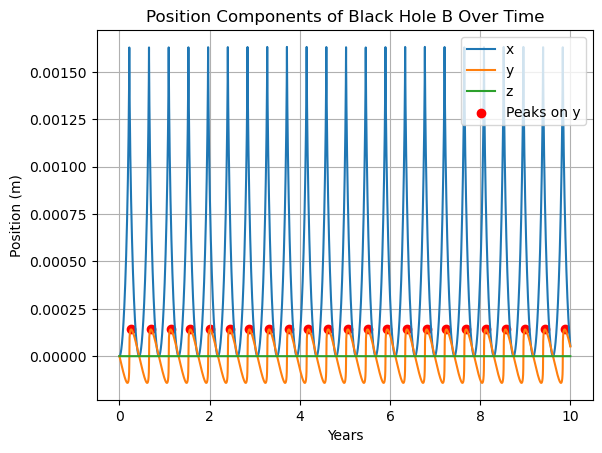

In [43]:
from scipy.signal import find_peaks


y_relative_to_center = r2_sol[:, 1] - rcom_sol[:, 1]


peaks, _ = find_peaks(y_relative_to_center)


if len(peaks) >= 2:
    first_peak_time = time_span[peaks[0]]
    second_peak_time = time_span[peaks[1]]
    orbital_period = second_peak_time - first_peak_time
    orbital_period_years = orbital_period
    print(f"Simulated Orbital Period: {orbital_period_years:.6f} years")


    plt.plot(time_span, r2_sol[:, 0], label='x')
    plt.plot(time_span, r2_sol[:, 1], label='y')
    plt.plot(time_span, r2_sol[:, 2], label='z')


    plt.scatter(time_span[peaks], r2_sol[peaks, 1], color='red', label='Peaks on y')

    plt.xlabel('Years')
    plt.ylabel('Position (m)')
    plt.title('Position Components of Black Hole B Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Could not find two peaks to determine the orbital period.")

In [54]:
distance1 = np.linalg.norm(u.pc.to(u.m, r1_sol - rcom_sol), axis= 1)

p_distance1 = np.min(distance1)
a_distance1 = np.max(distance1)

distance2 = np.linalg.norm(u.pc.to(u.m, r1_sol - rcom_sol), axis = 1)

p_distance2 = np.min(distance2)
a_distance2 = np.max(distance2)



# Eccentricity
def compute_eccentricity(r_p, r_a):
    return (r_a - r_p) / (r_a + r_p)

# Semi-major axis
def compute_semi_major_axis(r_p, r_a):
    return ((r_a + r_p) / 2)

# Semi-minor axis
def compute_semi_minor_axis(a, e):
    return a * np.sqrt(1 - e**2)

# Orbital period
def compute_orbital_period(a, mu):
    return np.sqrt((4 * np.pi**2 / mu) * a**3)

# Theoretical data
# Eccentricity and Semi-Major Axis for Black Hole A
r_p1 = p_distance1
r_a1 = a_distance1
eccentricity1 = compute_eccentricity(r_p1, r_a1)
a1 = compute_semi_major_axis(r_p1, r_a1)

# Eccentricity and Semi-Major Axis for Black Hole B
r_p2 = p_distance2
r_a2 = a_distance2
eccentricity2 = compute_eccentricity(r_p2, r_a2)
a2 = compute_semi_major_axis(r_p2, r_a2)

# Semi Minor Axis for Black Hole A and B
b1 = compute_semi_minor_axis(a1, eccentricity1)
b2 = compute_semi_minor_axis(a2, eccentricity2)

# Orbital periods of the black holes
T1 = compute_orbital_period(a1, mu)
T2 = compute_orbital_period(a2, mu)


print(f"Eccentricity of the A orbit: {round(eccentricity1, 4)}") #WOOOOOOOH IT IS  0 < EPSILON < 1 !!!!
print(f"Eccentricity of the B orbit: {round(eccentricity2, 4)}") 
print(f"Semi-Major Axis of the orbit A: {round(u.m.to(u.pc,a1), 6)} pc")
print(f"Semi-Major Axis of the orbit B: {round(u.m.to(u.pc, a2), 6)} pc")
print(f"Semi-Minor Axis of the orbit A: {round(u.m.to(u.pc, b1), 6)} pc")
print(f"Semi-Minor Axis of the orbit B: {round(u.m.to(u.pc, b2), 6)} pc")
print(f"Theoretical Orbital Period of BH A: {round(u.s.to(u.year, T1), 6)} yrs")
print(f"Theoretical Orbital Period of BH B: {round(u.s.to(u.year, T2), 6)} yrs")
print(T1)


Eccentricity of the A orbit: 0.9849
Eccentricity of the B orbit: 0.9849
Semi-Major Axis of the orbit A: 0.000816 pc
Semi-Major Axis of the orbit B: 0.000816 pc
Semi-Minor Axis of the orbit A: 0.000141 pc
Semi-Minor Axis of the orbit B: 0.000141 pc
Theoretical Orbital Period of BH A: 0.154505 yrs
Theoretical Orbital Period of BH B: 0.154505 yrs
4875816.2064995235


In [45]:
distance1 = np.linalg.norm(r1_sol - r2_sol, axis= 1)
distance2 = np.linalg.norm(r1com_sol, axis= 1)

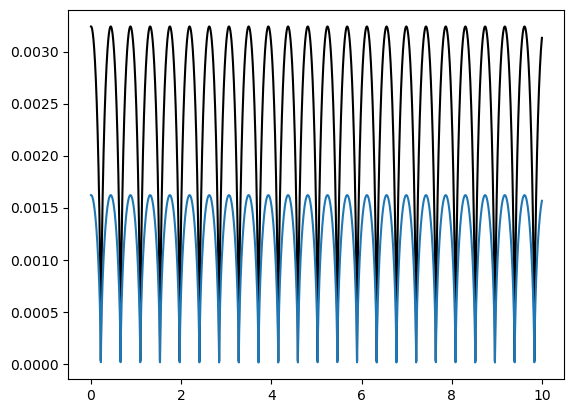

In [46]:
plt.plot(time_span, distance1, c = "k")
plt.plot(time_span, distance2)

In [ ]:
print(p_distance2)

379692341862.5177


/var/folders/rf/799sdl_537nf32dnhw741jq80000gn/T/ipykernel_9487/3269629294.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array([c1x, c1y, 0])


Simulated Orbital Period: 0.00e+00 year(s)
[3.05886118]


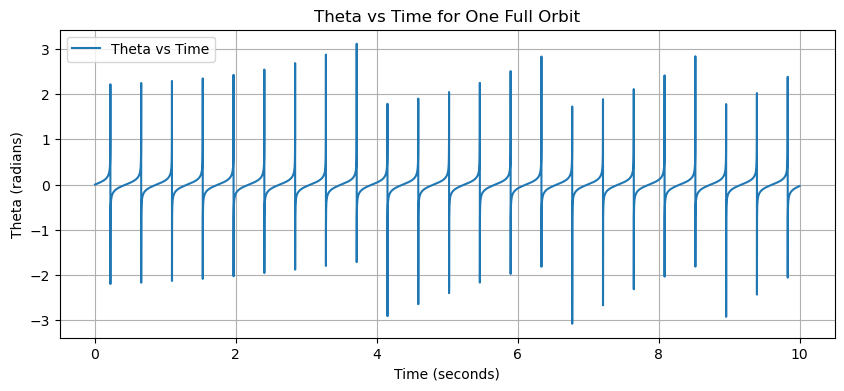

13790890.813740324


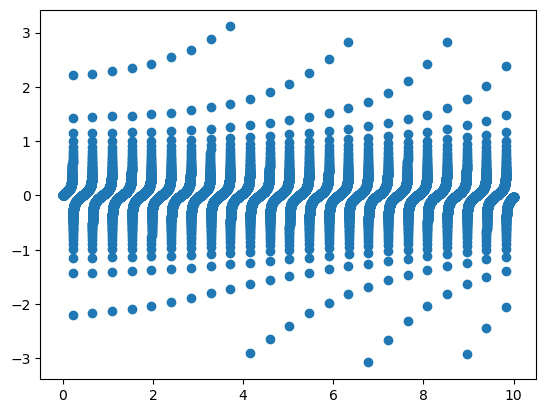

In [ ]:
#Check if simulated and observed are matching

# c1y = (np.max(r1_sol[:,1]) + np.min(r1_sol[:,1])) / 2
# c1x = (np.max(r1_sol[:,0]) + np.min(r1_sol[:,0])) / 2
# c1 = np.mean(r1_sol, axis=0)

c1x = rcom_sol[:,0]
c1y = rcom_sol[:,1]
c = np.array([c1x, c1y, 0])


angles = np.arctan2(u.pc.to(u.m, r1_sol[:, 1]) -  u.pc.to(u.m, rcom_sol[:,1]), u.pc.to(u.m, r1_sol[:, 0]) - u.pc.to(u.m, rcom_sol[:,0]))  # arctan2 gives the angle in radians


#- u.pc.to(u.m, c1[1])

# angles = np.mod(angles, 2 * np.pi)

# start_idx = np.where(np.diff(np.unwrap(angles)) < 0)[0] + 1  # Where angle decreases (start of new orbit)
# end_idx = start_idx  # End of first orbit is start of second orbit

# # Calculate simulated orbital periods
# orbit_periods = time_span[end_idx] - time_span[start_idx]

orbital_period = None
for i in range(1, len(angles)):
    if angles[i] == np.max(angles):
        orbital_period = time_span[i] - time_span[0]
        break

# Check if orbital_period was found
if orbital_period is not None:
    orbital_period_years = u.s.to(u.year, orbital_period)
    print(f"Simulated Orbital Period: {round(orbital_period_years, 3):.2e} year(s)")
else:
    print("No complete orbit found within the given data.")


# initial_angle = np.max(angles)
# orbital_period = None
# for i in range(1, len(angles)):
#     if np.isclose(angles[i], initial_angle, atol=1e-6):
#         orbital_period = time_span[i] - time_span[0]
#         break
# if orbital_period is not None:
#     orbital_period_years = u.s.to(u.year, orbital_period)
#     print(f"Simulated Orbital Period: {orbital_period_years:.2e} year(s)")
# else:
#     print("No complete orbit found within the given data.")

start = np.where(angles == np.max(angles))
end = np.where(angles == np.min(angles))

time = time_span[end] - time_span[start]
print(time)


plt.figure(figsize=(10, 4))
plt.plot(time_span, angles, label='Theta vs Time')
plt.xlim()
plt.xlabel('Time (seconds)')
plt.ylabel('Theta (radians)')
plt.title('Theta vs Time for One Full Orbit')
plt.grid(True)

plt.legend()
plt.show()


plt.scatter(time_span, angles)

print(T1)



Simulated Orbital Period: 0.437009 years


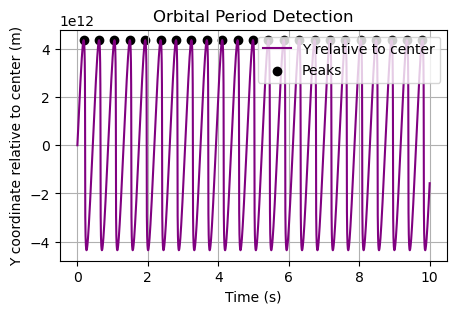

In [ ]:
from scipy.signal import find_peaks
y_relative_to_center = u.pc.to(u.m, r1_sol[:, 1] - rcom_sol[:, 1])


peaks, _ = find_peaks(y_relative_to_center)

if len(peaks) >= 8:
    first_peak_time = time_span[peaks[0]]
    second_peak_time = time_span[peaks[1]]
    orbital_period = second_peak_time - first_peak_time
    orbital_period_years = orbital_period
    print(f"Simulated Orbital Period: {orbital_period_years:4f} years")


    plt.figure(figsize=(5, 3))
    plt.plot(time_span, y_relative_to_center, label='Y relative to center', color='purple')
    plt.scatter(time_span[peaks], y_relative_to_center[peaks], color='black', label='Peaks')
    plt.xlabel('Time (s)')
    plt.ylabel('Y coordinate relative to center (m)')
    plt.title('Orbital Period Detection')
    plt.grid(True)
    plt.legend(loc = "upper right")
    plt.show()
else:
    print("Could not find two peaks to determine the orbital period.")


In [53]:
t = u.year.to(u.s, orbital_period_years)
print(t)

needed_a = ((t**2*mu)/(4*(np.pi)**2))**(1/3)

print(u.m.to(u.pc, needed_a))

13790947.018940378
0.001632699071562685


Simulated Orbital Period: 0.437009 years


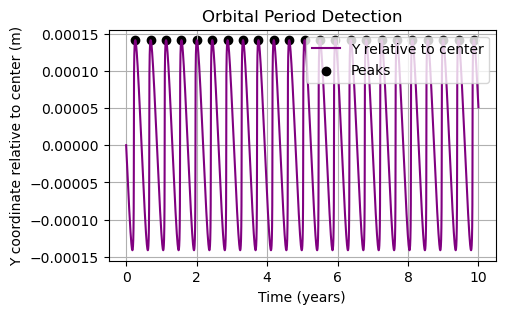

In [ ]:
# Calculate the y-coordinate relative to the center of mass
y_relative_to_center = r2_sol[:, 1] - rcom_sol[:, 1]

# Find peaks in the y-coordinate relative to the center of mass
peaks, _ = find_peaks(y_relative_to_center)

# Calculate the orbital period based on the detected peaks
if len(peaks) >= 2:
    first_peak_time = time_span[peaks[0]]
    second_peak_time = time_span[peaks[1]]
    orbital_period = second_peak_time - first_peak_time
    orbital_period_years = orbital_period
    print(f"Simulated Orbital Period: {orbital_period_years:.6f} years")

    # Plot the y-coordinate relative to the center of mass
    plt.figure(figsize=(5, 3))
    plt.plot(time_span, y_relative_to_center, label='Y relative to center', color='purple')
    plt.scatter(time_span[peaks], y_relative_to_center[peaks], color='black', label='Peaks')
    plt.xlabel('Time (years)')
    plt.ylabel('Y coordinate relative to center (m)')
    plt.title('Orbital Period Detection')
    plt.grid(True)
    plt.legend(loc="upper right")
    plt.show()
else:
    print("Could not find two peaks to determine the orbital period.")

In [ ]:
#Calculations Using Positions

print(f"Theoretical Orbital Period of BH A: {round(u.s.to(u.year, T1), 6)} yrs")
print(f"Theoretical Orbital Period of BH B: {round(u.s.to(u.year, T2), 6)} yrs")
print(f"Simulated Orbital Period of BH A: {orbital_period_years} years")


percent_error = ((u.s.to(u.year, T1) - orbital_period_years) / u.s.to(u.year, T1)) * 100 * -1
print(f"Percent Error Using Positions = {round(percent_error, 4)} %")

Theoretical Orbital Period of BH A: 0.437007 yrs
Theoretical Orbital Period of BH B: 0.437007 yrs
Simulated Orbital Period of BH A: 0.43700874017480346 years
Percent Error Using Positions = 0.0004 %


Simulated Orbital Period: 0.4370 years


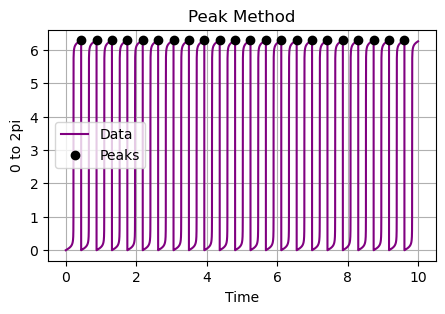

1st Peak Time: 0.44 yrs (Index: 2184)
2nd Peak Time: 0.87 yrs (Index: 4369)
Simulated Orbital Period: 0.4370 years


In [ ]:
from scipy.signal import find_peaks

#COM
# r1com_x = r1_sol_pc[:, 0] - rcom_sol[:, 0]
# r1com_y = r1_sol_pc[:, 1] - rcom_sol[:, 1]
# angles = np.arctan2(r1com_y, r1com_x)

c1y = (np.max(r1_sol[:,1]) + np.min(r1_sol[:,1])) / 2
c1x = (np.max(r1_sol[:,0]) + np.min(r1_sol[:,0])) / 2
c = np.array([u.pc.to(u.m,c1x), u.pc.to(u.m, c1y), 0])


# angles = np.arctan2(u.pc.to(u.m, r1_sol[:, 1]) -  c[1], u.pc.to(u.m, r1_sol[:, 0]) - c[0]) #apparently, using the center of the ellipses and the COM does not have affect on teh orbital period?



angles_norm = angles - angles[0]
angles_norm = np.mod(angles_norm, 2 * np.pi)


peaks, _ = find_peaks(angles_norm)


if len(peaks) >= 2:
    orbital_period = time_span[peaks[1]] - time_span[peaks[0]]
    orbital_period_years = orbital_period 
    print(f"Simulated Orbital Period: {orbital_period_years:.4f} years")
else:
    print("None")


plt.figure(figsize=(5, 3))
plt.plot(time_span, angles_norm, label='Data', color = 'purple')
plt.plot(time_span[peaks], angles_norm[peaks], 'o', color='black', label='Peaks')
plt.xlim()
plt.xlabel('Time')
plt.ylabel('0 to 2pi')
plt.title('Peak Method')
plt.grid(True)
plt.legend()
plt.show()

if len(peaks) >= 2:
    first_peak_time = time_span[peaks[0]]
    print(f"1st Peak Time: {first_peak_time:.2f} yrs (Index: {peaks[0]})")

    second_peak_time = time_span[peaks[1]]
    print(f"2nd Peak Time: {second_peak_time:.2f} yrs (Index: {peaks[1]})")

    orbital_period = second_peak_time - first_peak_time
    orbital_period_years = orbital_period 
    print(f"Simulated Orbital Period: {orbital_period_years:.4f} years")
else:
    print("None")

In [ ]:
#Calculations Using Angle


print(f"Theoretical Orbital Period of BH A: {round(u.s.to(u.year, T1), 6)} yrs")
print(f"Theoretical Orbital Period of BH B: {round(u.s.to(u.year, T2), 6)} yrs")
print(f"Simulated Orbital Period of BH A: {orbital_period_years} years")

percent_error = ((u.s.to(u.year, T1) - orbital_period_years) / u.s.to(u.year, T1)) * 100 
print(f"Percent Error Using Angles = {percent_error:4f} %")

Theoretical Orbital Period of BH A: 0.154505 yrs
Theoretical Orbital Period of BH B: 0.154505 yrs
Simulated Orbital Period of BH A: 0.4370087401748034 years
Percent Error Using Angles = -182.843865 %


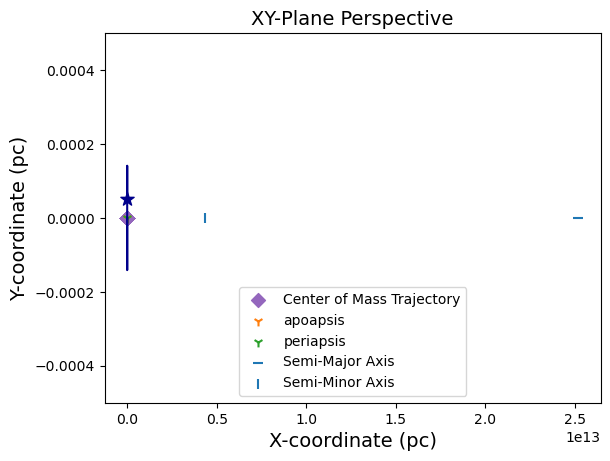

1.2304990778686771e-05 0.0016203896447221822


In [ ]:

plt.plot(r2_sol[:,0],r2_sol[:,1],color="darkblue")
# plt.plot(r2_sol[:,0],r2_sol[:,1],color="tab:red")
plt.scatter(rcom_sol[:, 0], rcom_sol[:, 1], color="tab:purple", marker = "D", s = 50, label="Center of Mass Trajectory")
plt.scatter(u.m.to(u.pc, r_a2), 0, color = "tab:orange",marker = "1" ,s = 50, label = "apoapsis")
plt.scatter(u.m.to(u.pc, r_p2), 0, color = "tab:green", marker = "1", s = 50, label = "periapsis")
# plt.scatter(, -b2, -a1, -b2, color = "tab:blue", s = 50)
plt.scatter(a2, 0, color = "tab:blue", s = 50, marker = "_", label = "Semi-Major Axis") #instead of using scatter
plt.scatter(b2, 0, color = "tab:blue", s = 50, marker = "|", label = "Semi-Minor Axis")
plt.ylim([-0.0005, 0.0005])
plt.scatter(r2_sol[-1,0],r2_sol[-1,1],color="darkblue",marker="*",s=100)
# plt.scatter(r2_sol[-1,0],r2_sol[-1,1],color="tab:red",marker="*",s=100)
plt.xlabel("X-coordinate (pc)",fontsize=14)
plt.ylabel("Y-coordinate (pc)",fontsize=14)
plt.title("XY-Plane Perspective",fontsize=14)
plt.legend(loc = "lower center")

plt.show()

print(u.m.to(u.pc,r_p1), u.m.to(u.pc,r_a1))

In [ ]:
print("Center of Mass:", r_com)

Center of Mass: [5.e+13 0.e+00 0.e+00]


(array([    1,     2,     3, ..., 49997, 49998, 49999]),)

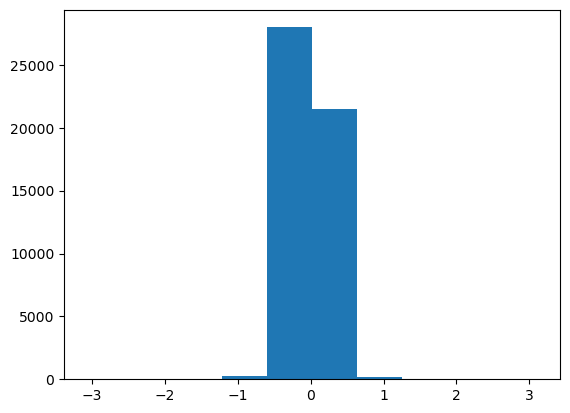

In [55]:

y = np.where((angles - angles[0]) <= 1e-4)[0]
x = np.arange(len(y))
# plt.plot(x,y)
y.shape

plt.hist(angles)
np.where(angles)


The average energy would be 2.6096731076275664e+82 J
The fractional energy would be 7.048583938740194e-17 J
Using the Fractional Energy method, we get the percent change of 6.402842700481415e-15 %


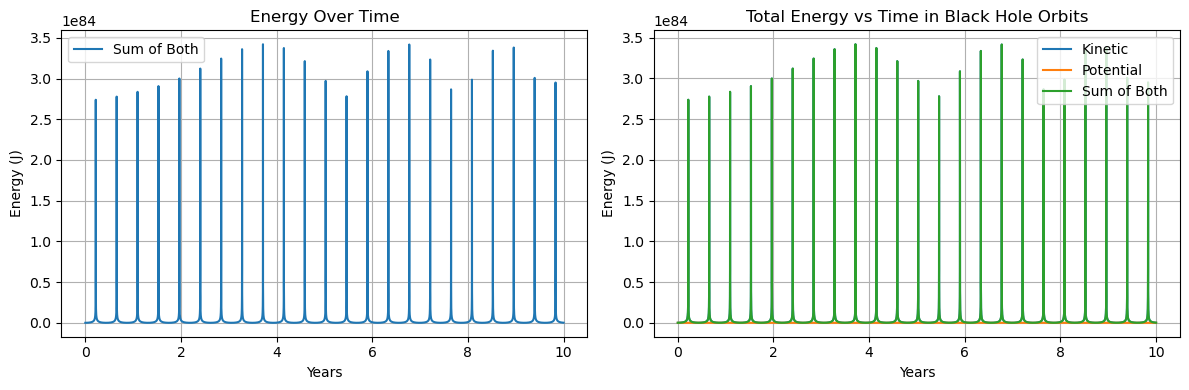

In [58]:
v1_sol = u.year.to(u.s, two_body_sol[:, 6:9])
v2_sol = u.year.to(u.s, two_body_sol[:, 9:12])

KE = (0.5 * m1.value * np.sum(v1_sol**2, axis=1)) + (0.5 * m2.value * np.sum(v2_sol**2, axis=1))
V = -const.G.value * (m1.value + m2.value) / np.linalg.norm(u.pc.to(u.m, (r1_sol - r2_sol)), axis = 1)
E = V + KE

time_span_year = time_span
avg_energy = np.mean(E)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# region Code Snippet 6: Energy Graph Plot

axs[0].plot(time_span_year, E, label = "Sum of Both")
axs[0].set_xlabel("Years")
axs[0].set_ylabel("Energy (J)")
axs[0].set_title("Energy Over Time")
axs[0].legend()
axs[0].grid()

# endregion
# region Code Snippet 7: Energy Graph Plot

axs[1].plot(time_span_year, KE, label="Kinetic")
axs[1].plot(time_span_year, V, label = "Potential") 
axs[1].plot(time_span_year, E, label = "Sum of Both")
axs[1].set_xlabel("Years")
axs[1].set_ylabel("Energy (J)")
axs[1].set_title("Total Energy vs Time in Black Hole Orbits")
axs[1].legend()
axs[1].grid()
# endregion

#Fractional Energy work >

frac_energy = (E - avg_energy) / avg_energy
percent = frac_energy * 100

print(f"The average energy would be {round(avg_energy,6)} J")
print(f"The fractional energy would be {np.mean(frac_energy)} J")
print(f"Using the Fractional Energy method, we get the percent change of {np.mean(percent)} %")

plt.tight_layout()
plt.show()


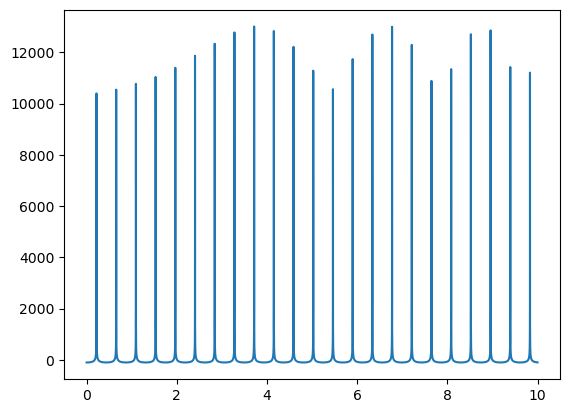

In [59]:
plt.plot(time_span_year, percent)

- review on the part where the switch from com to keplers thrid law (???)
- fit the ellpise equation to the orbit and then extract the semi major axis from teh orbit and plug into this formula and plot like a (did not work as I wanted to)
- chi2
- convert from angle to time correctly (find another way other than keplers law)


KeyboardInterrupt: 

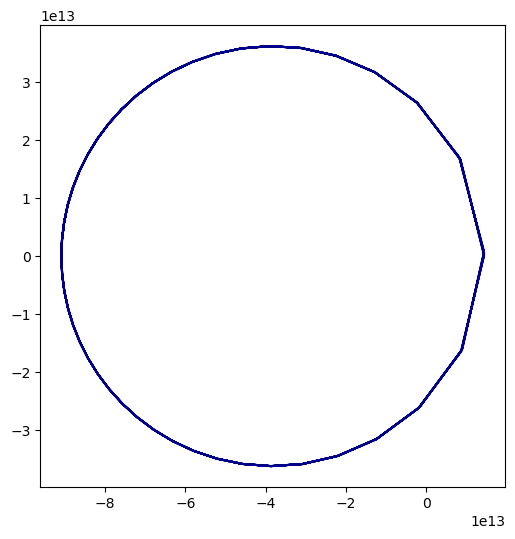

In [ ]:
import moviepy
from moviepy.editor import ImageSequenceClip
import os
frames_dir = "frames"
if not os.path.exists(frames_dir):
    os.makedirs(frames_dir)

# Generate frames
for i, (r1, r2) in enumerate(zip(r1com_sol, r2com_sol)):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(r1com_sol[:i+1, 0], r1com_sol[:i+1, 1], color="darkblue")
    ax.plot(r2com_sol[:i+1, 0], r2com_sol[:i+1, 1], color="tab:red")
    ax.scatter(r1[0], r1[1], color="darkblue", marker="*", s=100, label="Object A")
    ax.scatter(r2[0], r2[1], color="tab:red", marker="*", s=100, label="Object B")
    ax.set_xlabel("X-coordinate", fontsize=14)
    ax.set_ylabel("Y-coordinate", fontsize=14)
    ax.set_title("XY-Plane Perspective COM", fontsize=14)
    ax.legend()
    plt.savefig(f"{frames_dir}/frame_{i:04d}.png")
    plt.close()

print("Frames generated.")

In [ ]:
# Create a movie from the frames
frames = [f"{frames_dir}/frame_{i:04d}.png" for i in range(len(r1com_sol))]
clip = ImageSequenceClip(frames, fps=24) # You can adjust fps (frames per second)

# Save the movie
clip.write_videofile("black_hole_orbits.mp4", codec='libx264')


Moviepy - Building video black_hole_orbits.mp4.
Moviepy - Writing video black_hole_orbits.mp4



TypeError: must be real number, not NoneType

NameError: name 'R1_rel_COG' is not defined

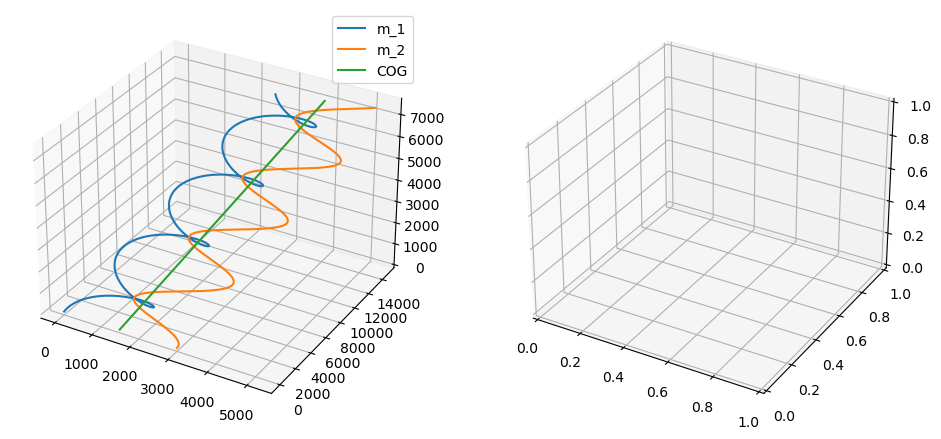

In [ ]:
import numpy as np

G = 6.67430e-20  # km**3/(kg * s**2)
m_1 = m_2 = 1.0e26  # kg

R_1_0 = np.array((0, 0, 0))  # km
R_2_0 = np.array((3000, 0, 0))  # km
dotR_1_0 = np.array((10, 20, 30))  # km/s
dotR_2_0 = np.array((0, 40, 0))  # km/s

y_0 = np.hstack((R_1_0, R_2_0, dotR_1_0, dotR_2_0))

X_1 = y_0[0]
Y_1 = y_0[1]
Z_1 = y_0[2]
X_2 = y_0[3]
Y_2 = y_0[4]
Z_2 = y_0[5]

r = np.sqrt((X_2 - X_1) ** 2 + (Y_2 - Y_1) ** 2 + (Z_2 - Z_1) ** 2)

ddotX_1 = G * m_2 * (X_2 - X_1) / r**3
ddotY_1 = G * m_2 * (Y_2 - Y_1) / r**3
ddotZ_1 = G * m_2 * (Z_2 - Z_1) / r**3
ddotX_2 = -G * m_1 * (X_2 - X_1) / r**3
ddotY_2 = -G * m_1 * (Y_2 - Y_1) / r**3
ddotZ_2 = -G * m_1 * (Z_2 - Z_1) / r**3

R_1 = y_0[:3]
R_2 = y_0[3:6]

r = np.sqrt(np.sum(np.square(R_2 - R_1)))
ddot = G * (R_2 - R_1) / r**3
ddotR_1_0 = m_2 * ddot
ddotR_2_0 = -m_1 * ddot

Delta_t = 1  # s
dotR_1_1 = ddotR_1_0 * Delta_t + dotR_1_0
dotR_2_1 = ddotR_2_0 * Delta_t + dotR_2_0

R_1_1 = dotR_1_0 * Delta_t + R_1_0
R_2_1 = dotR_2_0 * Delta_t + R_2_0

import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


def absolute_motion(t, y):
    """Calculate the motion of a two-body system in an inertial reference frame.

    The state vector ``y`` should be in the order:

    1. Coordinates of $m_1$
    2. Coordinates of $m_2$
    3. Velocity components of $m_1$
    4. Velocity components of $m_2$
    """
    # Get the six coordinates for m_1 and m_2 from the state vector
    R_1 = y[:3]
    R_2 = y[3:6]

    # Fill the derivative vector with zeros
    ydot = np.zeros_like(y)

    # Set the first 6 elements of the derivative equal to the last
    # 6 elements of the state vector, which are the velocities
    ydot[:6] = y[6:]

    # Calculate the acceleration terms and fill them in to the rest
    # of the derivative array
    r = np.sqrt(np.sum(np.square(R_2 - R_1)))
    ddot = G * (R_2 - R_1) / r**3
    ddotR_1 = m_2 * ddot
    ddotR_2 = -m_1 * ddot

    ydot[6:9] = ddotR_1
    ydot[9:] = ddotR_2
    return ydot


t_0 = 0  # seconds
t_f = 480  # seconds
t_points = np.linspace(t_0, t_f, 1000)

sol = solve_ivp(absolute_motion, [t_0, t_f], y_0, t_eval=t_points)

y = sol.y.T
R_1 = y[:, :3]  # km
R_2 = y[:, 3:6]  # km
V_1 = y[:, 6:9]  # km/s
V_2 = y[:, 9:]  # km/s
barycenter = (m_1 * R_1 + m_2 * R_2) / (m_1 + m_2)  # km

fig = plt.figure(figsize=(18, 6))

ax1 = fig.add_subplot(131, projection="3d")
ax1.plot(R_1[:, 0], R_1[:, 1], R_1[:, 2], label="m_1")
ax1.plot(R_2[:, 0], R_2[:, 1], R_2[:, 2], label="m_2")
ax1.plot(barycenter[:, 0], barycenter[:, 1], barycenter[:, 2], label="COG")
ax1.legend()

ax2 = fig.add_subplot(132, projection="3d")
ax2.plot(R1_rel_COG[:, 0], R1_rel_COG[:, 1], R1_rel_COG[:, 2], label="m_1")
ax2.plot(R2_rel_COG[:, 0], R2_rel_COG[:, 1], R2_rel_COG[:, 2], label="m_2")
ax2.plot(0, 0, 0, "ro", label="COG")
ax2.legend()

ax3 = fig.add_subplot(133, projection="3d")
ax3.plot(R2_rel_R1[:, 0], R2_rel_R1[:, 1], R2_rel_R1[:, 2], label="m_2")
ax3.plot(COG_rel_R1[:, 0], COG_rel_R1[:, 1], COG_rel_R1[:, 2], label="COG")
ax3.plot(0, 0, 0, "ro", label="m_1")
ax3.legend()

plt.show()


